# Looking for a pipeline for segmenting seeds in images

I am not an image processing expert so I had to search for an image processing pipeline that works for segmenting these low contrast images. This is almost certainly not the most efficient method for segmenting the seeds.

## Setup

In [1]:
import math
from collections import namedtuple
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# import pandas as pd
# import skimage
# from ipywidgets import fixed, interact
# from scipy import fft
# from scipy import ndimage as ndi
# from scipy import signal
# from scipy.cluster.vq import kmeans2
# from scipy.signal import convolve2d as conv2
from skimage import (  # data, exposure, feature,; graph, img_as_float, restoration
    color,
    draw,
    filters,
    io,
    measure,
    morphology,
    segmentation,
    transform,
    util,
)
from skimage.filters import rank  # , thresholding

You will need to change this location.

In [2]:
IMAGE_DIR = Path(".") / "data" / "images"

In [3]:
suffixes = (".jpeg", ".jpg", ".png")

PATHS = [p for p in IMAGE_DIR.glob("*.*") if p.suffix in suffixes]
image_path = PATHS[0]

In [4]:
BODY_THRESHOLD = 9_000
SEED_THRESHOLD = 15_000
HEAD_SEARCH_HEIGHT = 300
HEAD_SEARCH_RADII = list(range(-20, 21))

## Display a before & after manipulation pair of images

In [5]:
def two_up(input_image, output_image, output_title):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16, 8)
    )
    ax = axes.ravel()

    ax[0].imshow(input_image, cmap=plt.cm.gray)
    ax[0].set_title("before")
    ax[0].axis("off")

    ax[1].imshow(output_image, cmap=plt.cm.gray)
    ax[1].set_title(output_title)
    ax[1].axis("off")

    plt.show()
    return output_image

## Get initial gray scale image

uint8 18 254


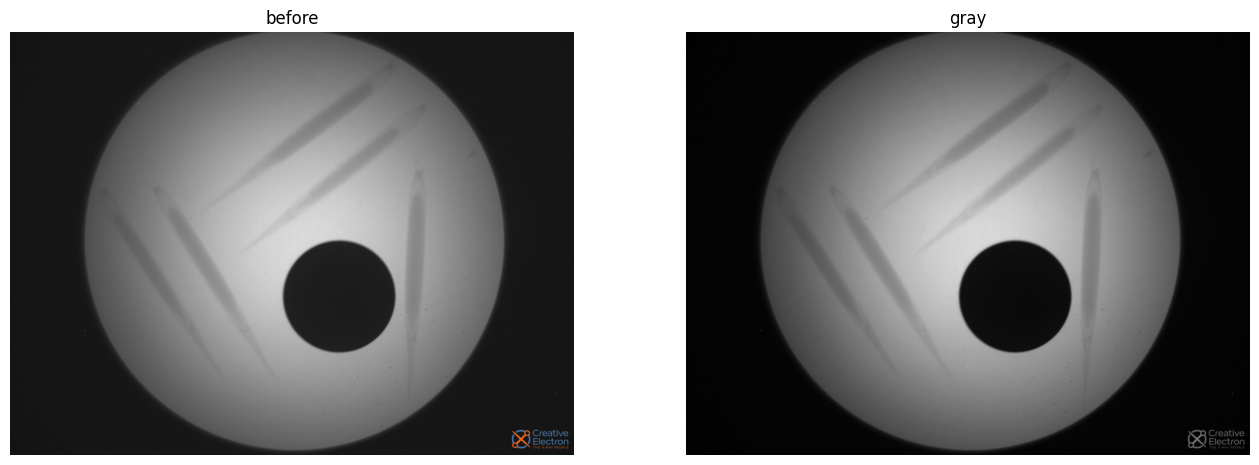

In [6]:
orig = io.imread(image_path)

gray = np.uint8(color.rgb2gray(orig) * 255.0)

print(gray.dtype, gray.min(), gray.max())

_ = two_up(orig, gray, "gray")

## Get a mask for the image

I don't want to perform image manipulations on the black regions of the image. Using this mask is important (autolevel_percentile needs it), however it introduces its own complications later on.

In [7]:
threshold = filters.threshold_otsu(gray)
mask = gray > threshold

mask = morphology.remove_small_objects(mask, 64)
mask = morphology.remove_small_holes(mask, 64)

Remove the watermark on the lower right corner. It will interfere with the image manipulations.

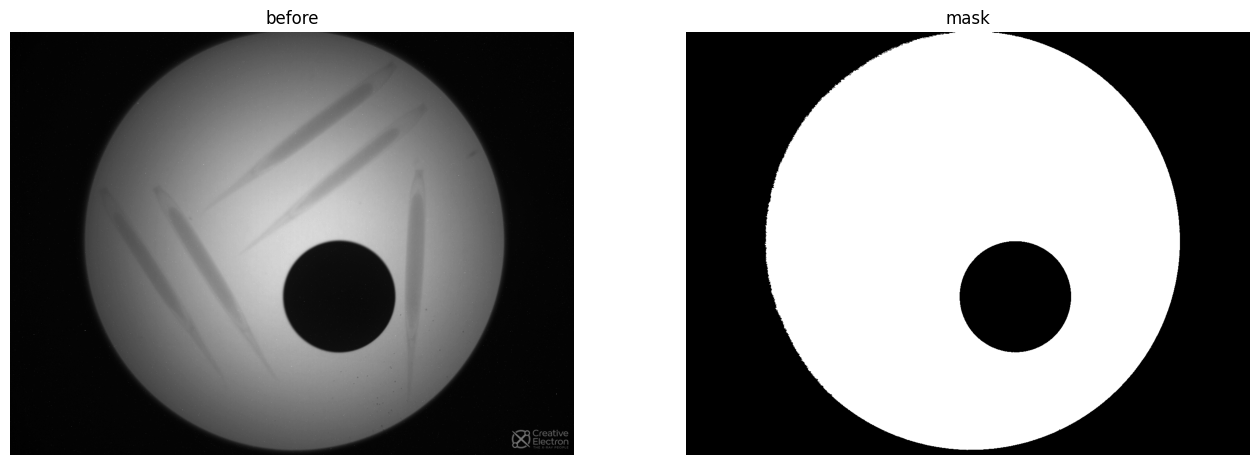

In [8]:
watermark_coords = (750, 1100)

rr, cc = draw.rectangle(watermark_coords, mask.shape, shape=mask.shape)
mask[rr, cc] = 0

_ = two_up(gray, mask, "mask")

## Enhance contrast

autolevel_percentile does and excellent job of enhancing the contrast of the seeds vs. the background. However, if you look at the before and after of the result closely you may notice that resulting black area has eaten into the seed staging area. Also notice that some of the dark seed heads are now touching the black back ground. I need to fix this.

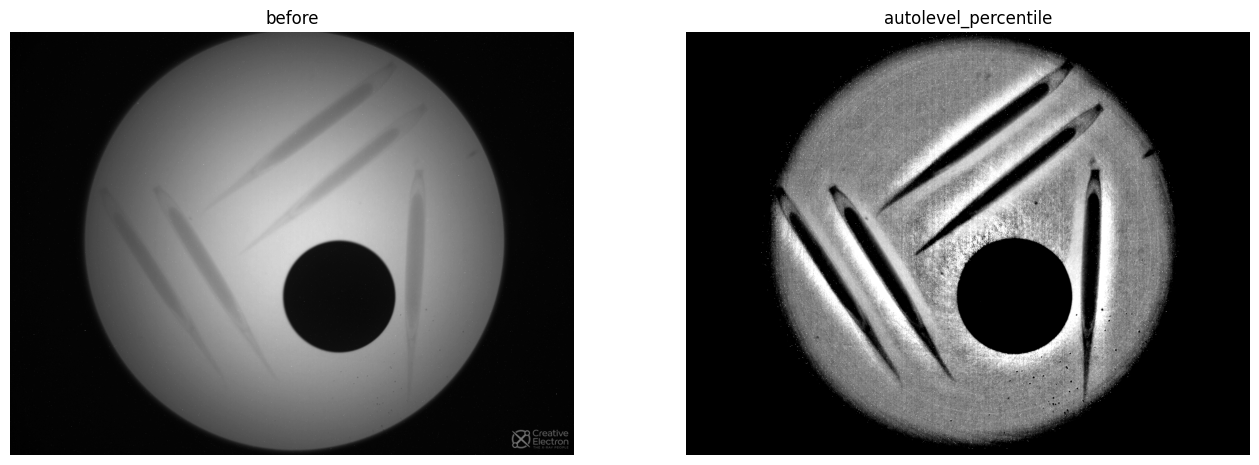

In [9]:
image = gray.copy()

disk, low, high = 50, 0.2, 0.8

new = rank.autolevel_percentile(
    image, footprint=morphology.disk(disk), p0=low, p1=high, mask=mask
)

image = two_up(image, new, "autolevel_percentile")

## Expand the mask edges

I'm between a rock & a hard place here. autolevel_percentile works really well at segmenting the low contrast image but it winds up having the seeds touch the black surrounding regions.

To counteract this I expand the width of the edges to get some of area back:
- Find the mask edges.
- Expand the outer outwards.
- Remove the inner circle completely.

#### Find mask edges

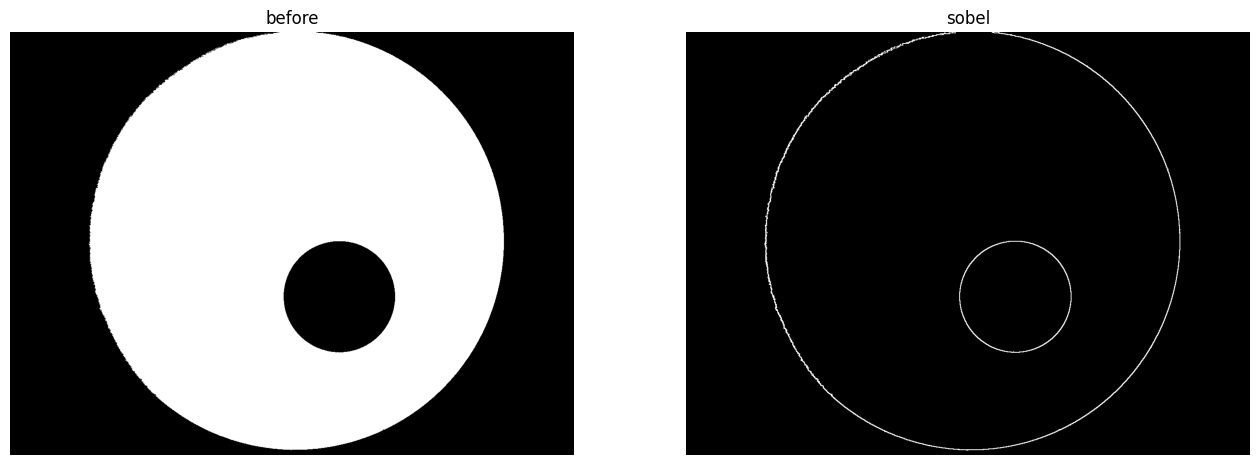

In [10]:
edges = filters.sobel(mask)
edges = edges > 0.2
_ = two_up(mask, edges, "sobel")

#### Find circles in image

In [11]:
small, large, count = 75, 500, 2

hough_radii = np.arange(small, large, 4)
hough_res = transform.hough_circle(edges, hough_radii)

# Select the most prominent circles
accums, cx, cy, radii = transform.hough_circle_peaks(
    hough_res, hough_radii, total_num_peaks=count
)

Circle = namedtuple("Circle", "x y radius")

circles = [Circle(y=y, x=x, radius=r) for y, x, r in zip(cy, cx, radii)]
circles = sorted(circles, key=lambda c: -c.radius)

In [12]:
big_circle, small_circle = circles
new_value = 128

#### Expand the small circle

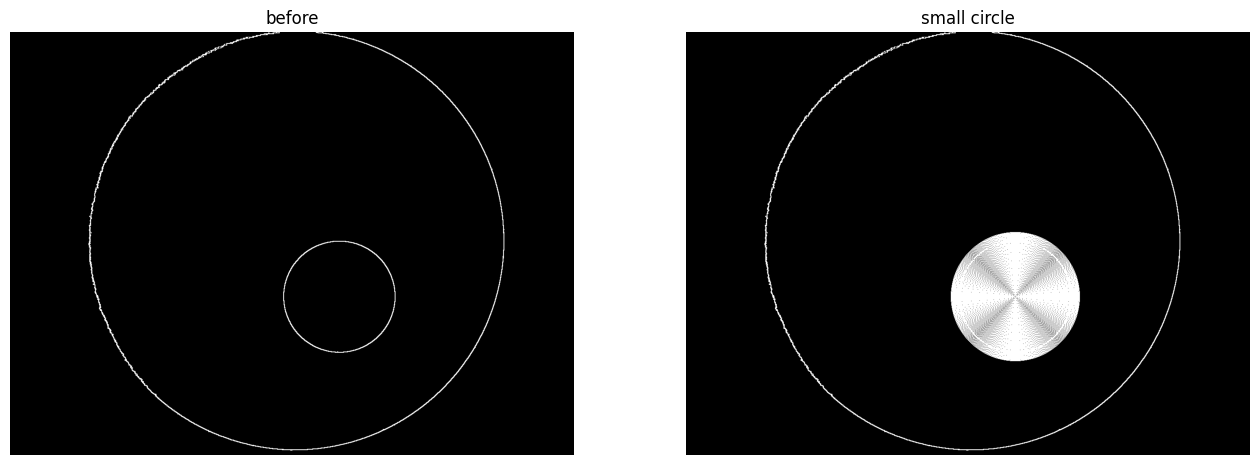

In [13]:
start, stop = 0, small_circle.radius + 20

new = edges.copy()

for radius in range(start, stop):
    circy, circx = draw.circle_perimeter(
        small_circle.y, small_circle.x, radius, shape=edges.shape
    )
    new[circy, circx] = new_value

edges = two_up(edges, new, "small circle")

#### Expand the big circle

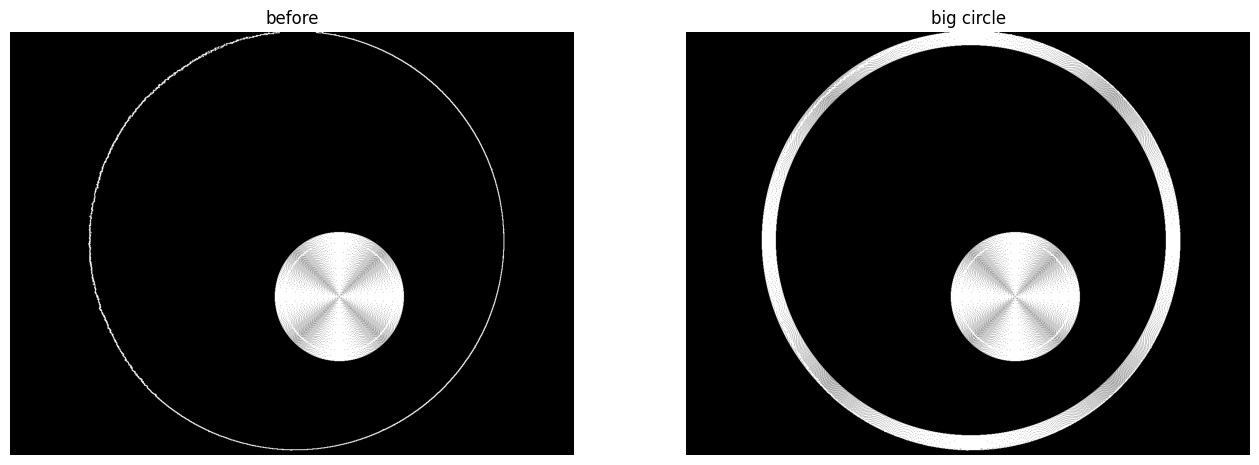

In [14]:
start, stop = big_circle.radius - 32, big_circle.radius

new = edges.copy()

for radius in range(start, stop):
    circy, circx = draw.circle_perimeter(
        big_circle.y, big_circle.x, radius, shape=edges.shape
    )
    new[circy, circx] = new_value

edges = two_up(edges, new, "big circle")

#### Fill area outside of the outer circle

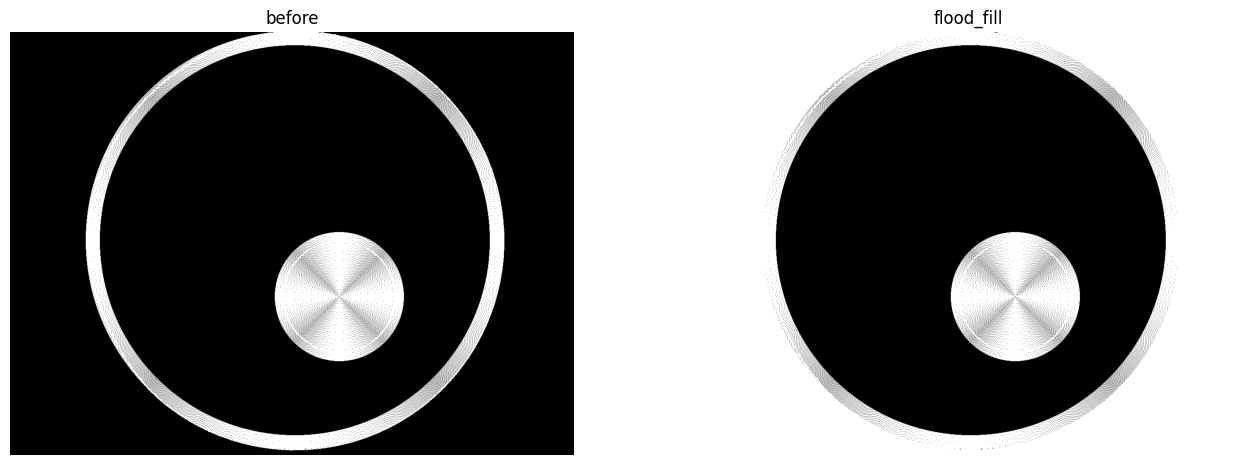

In [15]:
new_value = 128
seed_point = (1, 1)

new = segmentation.flood_fill(edges, seed_point, new_value)

edges = two_up(edges, new, "flood_fill")

## Threshold image

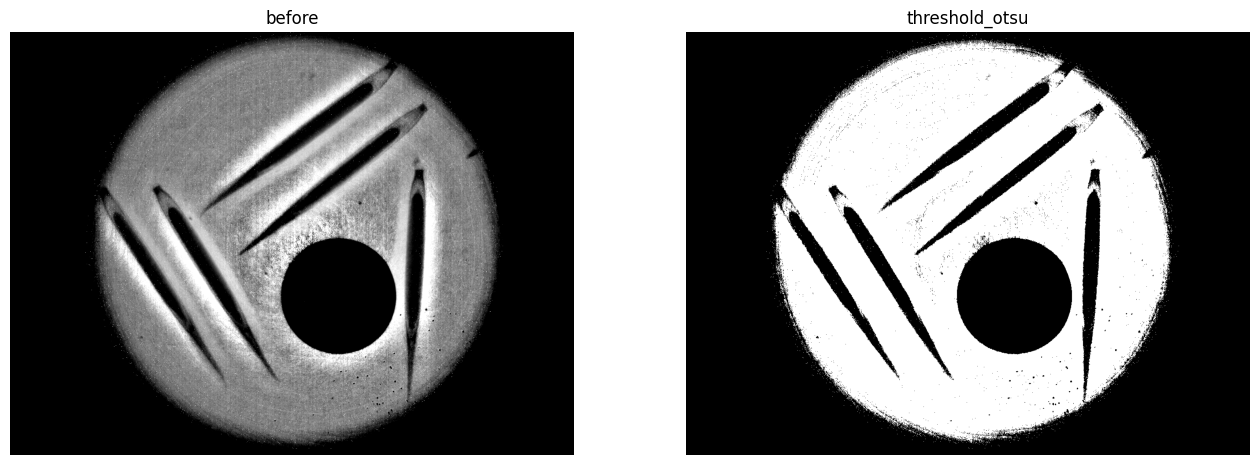

In [16]:
thresh = filters.threshold_otsu(image)
binary = image > thresh
binary = binary & mask

image = two_up(image, binary, "threshold_otsu")

## Apply the padded mask to the image

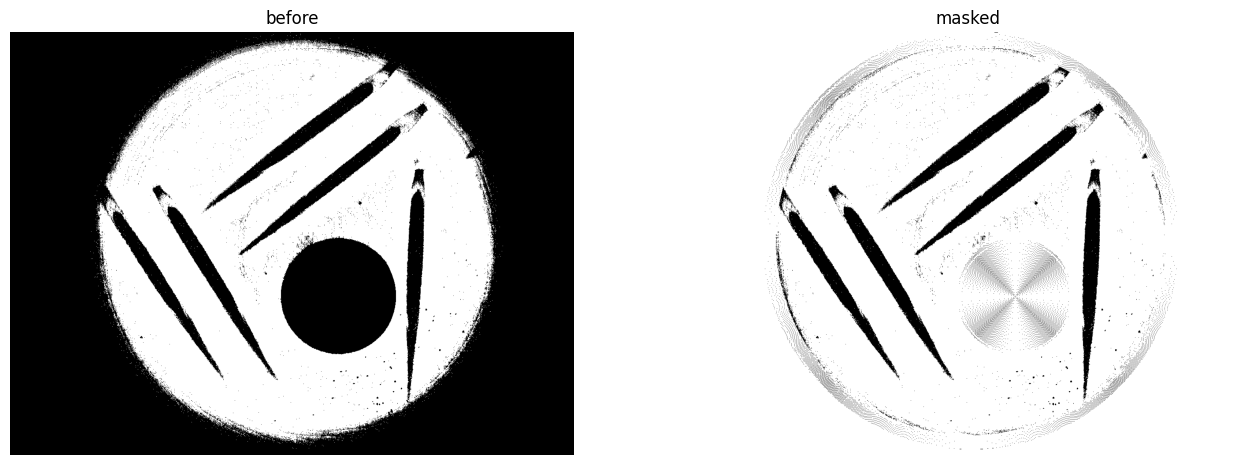

In [17]:
new = image.copy()
new[edges] = new_value
image = two_up(image, new, "masked")

## Clean up the image

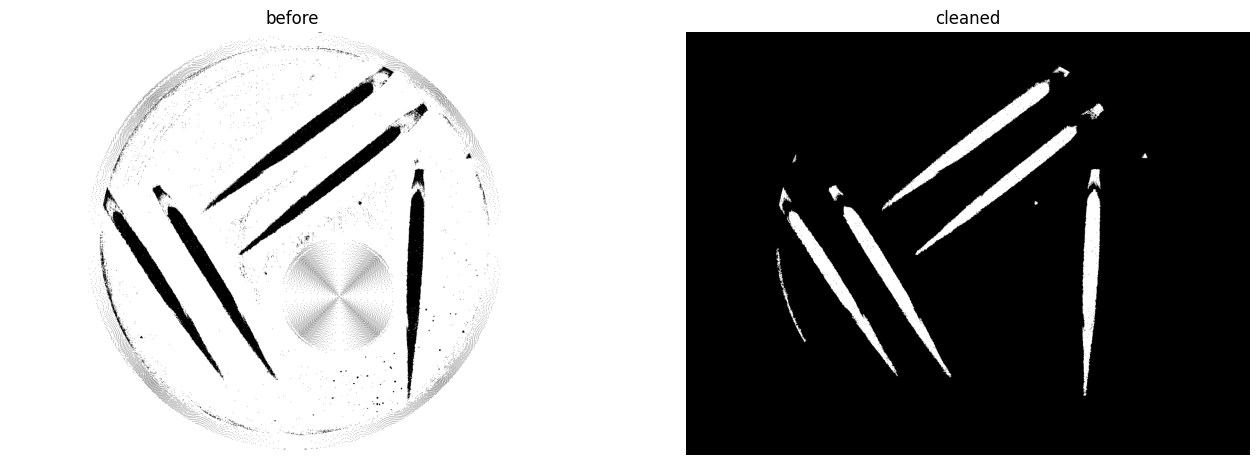

In [18]:
area_threshold = 32
new = morphology.remove_small_holes(image, area_threshold=area_threshold)
new = util.invert(new)
image = two_up(image, new, "cleaned")

## Find areas in the image

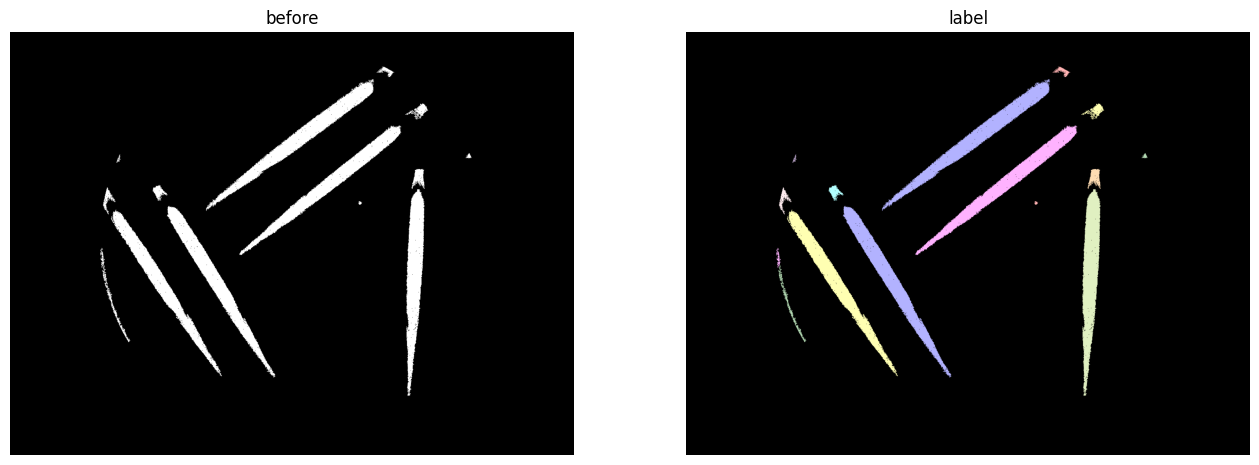

In [19]:
labels = measure.label(image)
overlay = color.label2rgb(labels, image, bg_label=0, bg_color=None)
image = two_up(image, overlay, "label")

## Join head & body

The head will sometimes get truncated near the top so I try to put it back on.

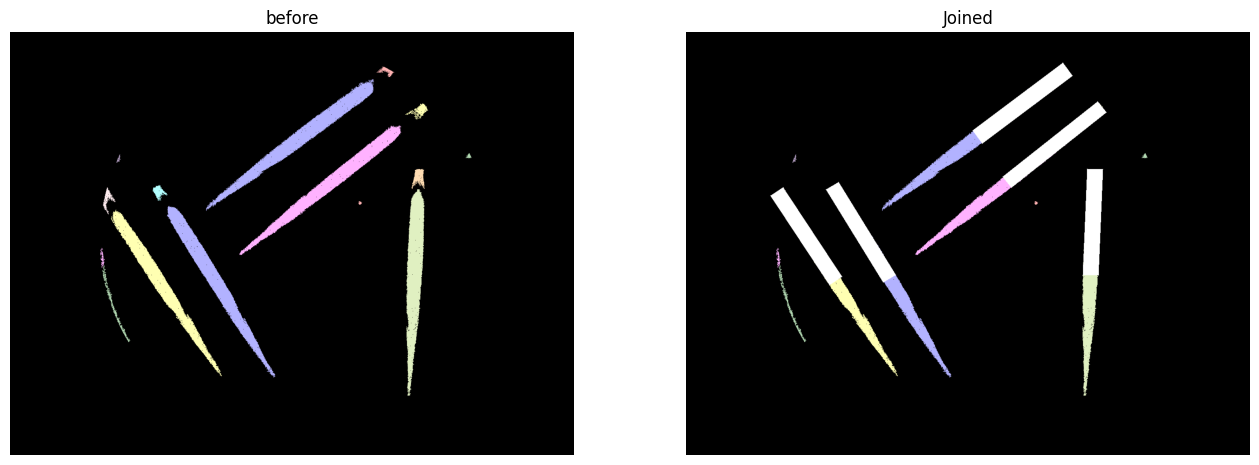

float64 (960, 1280, 3)


In [20]:
canvas = image.copy()

for body in measure.regionprops(labels):
    if body.area < BODY_THRESHOLD:
        continue

    # Start with the centroid calculated by scikit's measure.label function
    centroid_rr, centroid_cc = int(body.centroid[0]), int(body.centroid[1])
    # rr, cc = draw.disk((centroid_rr, centroid_cc), 4)
    # canvas[rr, cc] = (0, 1, 0)

    # Precalculate some orientation parameters
    cos = math.cos(body.orientation)  # parallel
    sin = math.sin(body.orientation)

    cos2 = math.cos(body.orientation + math.pi / 2)  # perpendicular
    sin2 = math.sin(body.orientation + math.pi / 2)

    # Scan for the tallest head point
    top, top_rr, top_cc = 0, None, None
    belt1, belt1_lo_rr, belt1_lo_cc = 999, None, None
    belt2, belt2_lo_rr, belt2_lo_cc = -999, None, None

    hi_rr = int(centroid_rr - HEAD_SEARCH_HEIGHT * cos)
    hi_cc = int(centroid_cc - HEAD_SEARCH_HEIGHT * sin)
    # rr, cc = draw.disk((hi_rr, hi_cc), 4)
    # canvas[rr, cc] = (1, 0, 0)

    for radius in HEAD_SEARCH_RADII:
        lo_rr = int(centroid_rr + radius * cos2)
        lo_cc = int(centroid_cc + radius * sin2)

        delta_rr, delta_cc = lo_rr - centroid_rr, lo_cc - centroid_cc

        line_rr, line_cc = draw.line(lo_rr, lo_cc, hi_rr + delta_rr, hi_cc + delta_cc)
        # canvas[line_rr, line_cc] = (1, 0, 0)

        idx = np.argwhere(image[line_rr, line_cc])
        if idx.size == 0:
            continue

        nonzero_rr = int(line_rr[idx[-1][0]])
        nonzero_cc = int(line_cc[idx[-1][0]])
        # rr, cc = draw.disk((nonzero_rr, nonzero_cc), 4)
        # canvas[rr, cc] = (1, 0, 0)

        dist = np.linalg.norm([lo_rr - nonzero_rr, lo_cc - nonzero_cc])
        if dist > top:
            top = dist
            top_rr, top_cc = nonzero_rr, nonzero_cc

        if radius < belt1:
            belt1 = radius
            belt1_lo_rr, belt1_lo_cc = lo_rr, lo_cc

        if radius > belt2:
            belt2 = radius
            belt2_lo_rr, belt2_lo_cc = lo_rr, lo_cc

    # rr, cc = draw.disk((belt1_lo_rr, belt1_lo_cc), 4)
    # canvas[rr, cc] = (0, 1, 1)

    hi_rr = int(centroid_rr - top * cos)
    hi_cc = int(centroid_cc - top * sin)

    delta1_rr, delta1_cc = belt1_lo_rr - centroid_rr, belt1_lo_cc - centroid_cc

    # belt1_rr, belt1_cc = draw.line(
    #     belt1_lo_rr, belt1_lo_cc, hi_rr + delta1_rr, hi_cc + delta1_cc
    # )
    # canvas[belt1_rr, belt1_cc] = (1, 0, 0)

    delta2_rr, delta2_cc = belt2_lo_rr - centroid_rr, belt2_lo_cc - centroid_cc

    # belt2_rr, belt2_cc = draw.line(
    #     belt2_lo_rr, belt2_lo_cc, hi_rr + delta2_rr, hi_cc + delta2_cc
    # )
    # canvas[belt2_rr, belt2_cc] = (1, 0, 0)
    rr, cc = draw.polygon(
        (belt1_lo_rr, hi_rr + delta1_rr, hi_rr + delta2_rr, belt2_lo_rr),
        (belt1_lo_cc, hi_cc + delta1_cc, hi_cc + delta2_cc, belt2_lo_cc),
    )
    # canvas[rr, cc] = (1, 0, 1)
    image[rr, cc] = (1, 1, 1)

    # rr, cc = draw.disk((top_rr, top_cc), 4)
    # canvas[rr, cc] = (0, 0, 1)

two_up(canvas, image, "Joined")
print(image.dtype, image.shape)

## Cutout seeds

In [21]:
canvas = image.copy()

canvas = np.uint8(color.rgb2gray(canvas) * 255.0)
# canvas = threshold_otsu(canvas)

thresh = filters.threshold_otsu(canvas)
binary = image > thresh
binary = binary & mask

canvas = two_up(image, binary, "threshold_otsu")

canvas = util.img_as_ubyte(canvas)
labels = label(canvas)

image = color.label2rgb(labels, image=image, bg_label=0)

ValueError: operands could not be broadcast together with shapes (960,1280,3) (960,1280) 

In [ ]:
for seed in regionprops(labels):
    if seed.area < SEED_THRESHOLD:
        continue

    tt, ll, bb, rr = seed.bbox

    area = gray[tt:bb, ll:rr].copy()
    area = exposure.rescale_intensity(area)

    area *= seed.image_convex
    # area[~seed.image_convex] = 0  # (0, 0, 0)

    # unique, counts = np.unique(area, return_counts=True)
    # print(list(zip(unique, counts)))

    print(area.dtype, area.shape)

    # print(area)
    # break

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax.imshow(area, cmap=plt.cm.gray)
    ax.set_title("seed")
    ax.axis("off")

    plt.show()
    break